In [1]:
import gym, time
import numpy as np
from stable_baselines3 import SAC
from gym_unbalanced_disk import UnbalancedDisk
from gym_unbalanced_disk import *
from gym import spaces

def normalize(theta):
    return (theta+np.pi)%(2*np.pi) - np.pi

class Multi_target(UnbalancedDisk):
    def __init__(self, umax=3., dt = 0.025, target= np.pi):  # observation [angle,omega,target satisfy info]  target satisfy info: inside area 1, out -1, 也许0？
        self.target = target
        self.count = 0
        super(Multi_target,self).__init__(umax=umax, dt=dt) # use SAC do not need discretize action 
        low  = [-np.pi,-40.,-np.pi]
        high = [np.pi,40.,np.pi]
        self.observation_space = spaces.Box(low=np.array(low,dtype=np.float32),high=np.array(high,dtype=np.float32),shape=(3,))
        # self.statu_left = 0
        # self.statu_right = 0
        # self.statu_mid = 0
        
    
    def get_obs(self):
        self.th_noise = self.th + np.random.normal(loc=0,scale=0.001) #do not edit
        self.omega_noise = self.omega + np.random.normal(loc=0,scale=0.001) #do not edit
        self.th_noise =normalize(self.th_noise)
        self.count +=1

        # if abs(self.th_noise -(np.radians(10)-np.pi))<0.01: # next to left target
        #     self.statu_mid = 0
        #     self.statu_left = 1
        #     self.statu_right =0
        #     self.count=0
        #     print('reach left')
        # if abs(self.th_noise -(np.pi-np.radians(10)))<0.01: # next to right target
        #     self.statu_mid = 0
        #     self.statu_left = 0
        #     self.statu_right = 1 
        #     self.count=0
        #     print('reach right')               
        # if abs(self.th_noise)-np.pi <0.01:
        #     self.statu_mid = 1
        #     self.statu_left = 0
        #     self.statu_right =0
        #     self.count=0
        #     print('reach top')
        # if self.count >=100:
        #     self.statu_mid = 0
        #     self.statu_left = 0
        #     self.statu_right =0
        #     self.count=0
              
        self.target = self.task_switch()
        
        self.obs = np.array([self.th_noise, self.omega_noise,self.target])
        return np.array([self.th_noise, self.omega_noise,self.target])

    def task_switch(self):
        num = (self.count//200)%4
        if num == 0 or num == 2 :
            target = np.pi
        elif num ==1 :
            target = np.pi - np.radians(10)
        else:
            target = - np.pi + np.radians (10)

        # if self.statu_mid == 1 and self.statu_left ==0 and self.statu_right ==0: # reach top
        #     target = np.radians(10)-np.pi # go to left
        #     print('Top reach')
        # elif self.statu_mid == 0 and self.statu_left ==1 and self.statu_right ==0: # reach left
        #     target = np.pi - np.radians(10) # go to right
        #     print('Left reach')
        # elif self.statu_mid == 0 and self.statu_left ==0 and self.statu_right ==1 : #reach right
        #     target = np.pi # go to middle
        #     self.statu_mid= 0
        #     self.statu_left=0
        #     self.statu_right=0
        #     print('Right reach')
        # else:
        #     target = np.pi


        # if normalize(self.th)< np.radians(10)-np.pi or normalize(self.th)> np.pi-np.radians(10): # in the area  
        #     if self.statu_left ==0 and self.statu_right==0: # didn't reach left.
        #         target = np.radians(10)-np.pi # left target  设置一个计数器，达成left 指定为1，也设定right 计数器！
        #     if self.statu_left ==1 and self.statu_right==0: # reach left
        #         target = np.pi - np.radians(10) # right target
        #         print('Left reach')
        #     if self.statu_left == 1 and self.statu_right ==1:
        #         target = np.radians(10)-np.pi
        #         self.statu_left = 0  # reset
        #         self.statu_right = 0
        #         print('Right reach')
        # else:
        #     target = np.pi

        # if target != self.target:
        #     print(f"Target shift happens: {target}")
        return target

    def reset(self):
        self.th = np.random.normal(loc=0,scale=0.001)
        self.omega = np.random.normal(loc=0,scale=0.001)
        self.u = 0
        self.count = -1
        return self.get_obs()
    
    def reward_fun(self):
        theta = normalize(self.th_noise)
        action = self.u
        if abs(theta-self.target)>np.pi: # superior arcs and inferior arcs  优弧 劣弧 问题
            diff = 2*np.pi-np.abs(theta-self.target)
        else:
            diff = np.abs(theta-self.target)

        #reward_th =  np.exp(- (diff)**2/(2*(np.pi/10)**2))
        
        
        # ## reward 2 --not working 
        # if np.pi-abs(theta) < np.radians(90):
        #     reward = reward_th -0.1*abs(self.omega)
        # elif np.pi-abs(theta) < np.radians(10) and self.omega<0.05:
        #     reward = reward_th + (3-abs(action))
        # else:
        #     reward = -150*diff**2  - 0.15*self.omega**2 -  1e-3*action**2
        
        
        ## reward 3 , swing up but cannot stop
        reward= -150*diff**2 - 0.15* self.omega**2 - 1e-3*action**2
        
        return reward
        

        

IF train, run this.

In [2]:
# max_episode_steps = 1000
# #env = gym.make('unbalanced-disk-v0', dt=0.025, umax=3.)
# env = Multi_target(umax=3., dt = 0.025,target= np.pi)
# env = gym.wrappers.time_limit.TimeLimit(env, max_episode_steps=max_episode_steps)

# model = SAC("MlpPolicy", env, learning_rate=0.01, verbose=1)
# model.learn(total_timesteps=5000)
# model.save('model/SAC_test')

IF only want to check best model uncomment this

In [3]:
import gym, time
import numpy as np
from stable_baselines3 import SAC
from gym_unbalanced_disk import UnbalancedDisk
from gym_unbalanced_disk import *
from gym import spaces
import os

def normalize(theta):
    return (theta+np.pi)%(2*np.pi) - np.pi


class Multi_target(UnbalancedDisk):
    def __init__(self, umax=3., dt = 0.025, target= np.pi):  # observation [angle,omega,target satisfy info]  target satisfy info: inside area 1, out -1, 也许0？
        self.target = target
        self.count = 0
        super(Multi_target,self).__init__(umax=umax, dt=dt) # use SAC do not need discretize action 
        low  = [-np.pi,-40.,-np.pi]
        high = [np.pi,40.,np.pi]
        self.observation_space = spaces.Box(low=np.array(low,dtype=np.float32),high=np.array(high,dtype=np.float32),shape=(3,))
        # self.statu_left = 0
        # self.statu_right = 0
        # self.statu_mid = 0
        
    
    def get_obs(self):
        self.th_noise = self.th + np.random.normal(loc=0,scale=0.001) #do not edit
        self.omega_noise = self.omega + np.random.normal(loc=0,scale=0.001) #do not edit
        self.th_noise =normalize(self.th_noise)
        self.count +=1
        self.target = self.task_switch()
        
        self.obs = np.array([self.th_noise, self.omega_noise,self.target])
        return np.array([self.th_noise, self.omega_noise,self.target])

    def task_switch(self):
        num = (self.count//200)%4
        if num == 0 or num == 2 :
            target = np.pi
        elif num ==1 :
            target = np.pi - np.radians(10)
        else:
            target = - np.pi + np.radians (10)
        return target

    def reset(self):
        self.th = np.random.normal(loc=0,scale=0.001)
        self.omega = np.random.normal(loc=0,scale=0.001)
        self.u = 0
        self.count = -1
        return self.get_obs()
    
    def reward_fun(self):
        theta = normalize(self.th_noise)
        action = self.u
        if abs(theta-self.target)>np.pi: # superior arcs and inferior arcs  优弧 劣弧 问题
            diff = 2*np.pi-np.abs(theta-self.target)
        else:
            diff = np.abs(theta-self.target)

        reward= -150*diff**2 - 0.15* self.omega**2 - 1e-3*action**2 
        return reward
        


max_episode_steps = 1000
#env = gym.make('unbalanced-disk-v0', dt=0.025, umax=3.)
env = Multi_target(umax=3., dt = 0.025,target= np.pi)
env = gym.wrappers.time_limit.TimeLimit(env, max_episode_steps=max_episode_steps)

best_model=os.path.join('..','saved_model','SAC_Best.zip')
model = SAC.load(best_model)
#model = SAC.load('model/so far best model/SAC_Best.zip')
obs = env.reset()
angle_list = []
target_list = []
reward_list = []
cum_reward_list = []
cum_reward = 0
try:
    for i in range(5000):
        # num = (i//200)%4
        # if num == 0 or num== 2:
        #     target = np.pi
        # elif num == 1:
        #     target = np.pi - np.radians(10)
        # else: 
        #     target = -np.pi + np.radians(10)
        obs[2] =  -np.pi + np.radians(10)
        action, _states = model.predict(obs)  # policy
        obs, reward, done, info = env.step(action)  # interact
        env.render()
        print(f'target = {obs[2]: .4f}, theta = {obs[0]: .4f}')
        time.sleep(1/120)
        angle_list.append(normalize(obs[0]))
        target_list.append(obs[2])
        reward_list.append(reward)
        cum_reward += reward
        cum_reward_list.append(cum_reward)
finally:
    env.close()

pygame 2.3.0 (SDL 2.24.2, Python 3.9.16)
Hello from the pygame community. https://www.pygame.org/contribute.html
target =  3.1416, theta =  0.0217
target =  3.1416, theta =  0.0877
target =  3.1416, theta =  0.1907
target =  3.1416, theta =  0.3207
target =  3.1416, theta =  0.4734
target =  3.1416, theta =  0.6296
target =  3.1416, theta =  0.7823
target =  3.1416, theta =  0.9232
target =  3.1416, theta =  1.0407
target =  3.1416, theta =  1.1376
target =  3.1416, theta =  1.2066
target =  3.1416, theta =  1.2481
target =  3.1416, theta =  1.2608
target =  3.1416, theta =  1.2290
target =  3.1416, theta =  1.1071
target =  3.1416, theta =  0.8689
target =  3.1416, theta =  0.5359
target =  3.1416, theta =  0.1237
target =  3.1416, theta = -0.3288
target =  3.1416, theta = -0.7875
target =  3.1416, theta = -1.2070
target =  3.1416, theta = -1.5748
target =  3.1416, theta = -1.8974
target =  3.1416, theta = -2.1613
target =  3.1416, theta = -2.3455
target =  3.1416, theta = -2.4749
tar

Visualization and plot

In [4]:
import os
best_model=os.path.join('..','saved_model','SAC_Best.zip')
model = SAC.load(best_model)
#model = SAC.load('model/so far best model/SAC_Best.zip')
obs = env.reset()
angle_list = []
target_list = []
reward_list = []
cum_reward_list = []
cum_reward = 0
try:
    for i in range(5000):
        #num = (i//200)%2
        #if num == 0 :
        #target = np.pi- np.radians(10)
        #elif num == 1:
           # target = np.pi 
        #else: 
        target = -np.pi + np.radians(10)
        obs[2] =  target
        action, _states = model.predict(obs)  # policy
        obs, reward, done, info = env.step(action)  # interact
        env.render()
        print(f'target = {obs[2]: .4f}, theta = {obs[0]: .4f}')
        time.sleep(1/120)
        angle_list.append(normalize(obs[0]))
        target_list.append(obs[2])
        reward_list.append(reward)
        cum_reward += reward
        cum_reward_list.append(cum_reward)
finally:
    env.close()

target =  3.1416, theta =  0.0241
target =  3.1416, theta =  0.0892
target =  3.1416, theta =  0.1918
target =  3.1416, theta =  0.3261
target =  3.1416, theta =  0.4773
target =  3.1416, theta =  0.6354
target =  3.1416, theta =  0.7897
target =  3.1416, theta =  0.9293
target =  3.1416, theta =  1.0504
target =  3.1416, theta =  1.1463
target =  3.1416, theta =  1.2130
target =  3.1416, theta =  1.2552
target =  3.1416, theta =  1.2651
target =  3.1416, theta =  1.2336
target =  3.1416, theta =  1.1121
target =  3.1416, theta =  0.8767
target =  3.1416, theta =  0.5456
target =  3.1416, theta =  0.1367
target =  3.1416, theta = -0.3144
target =  3.1416, theta = -0.7766
target =  3.1416, theta = -1.2037
target =  3.1416, theta = -1.5668
target =  3.1416, theta = -1.8660
target =  3.1416, theta = -2.1100
target =  3.1416, theta = -2.2879
target =  3.1416, theta = -2.4089
target =  3.1416, theta = -2.5164
target =  3.1416, theta = -2.6027
target =  3.1416, theta = -2.6635
target =  3.14

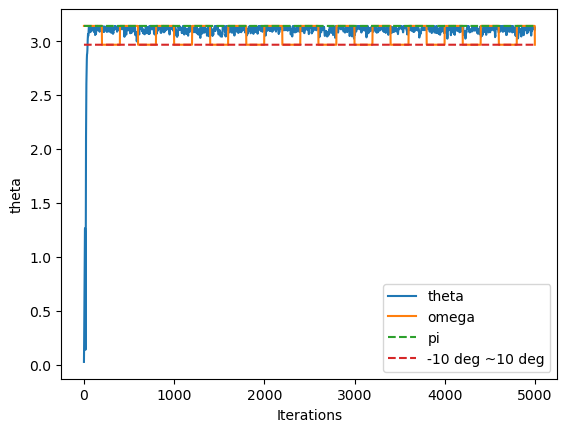

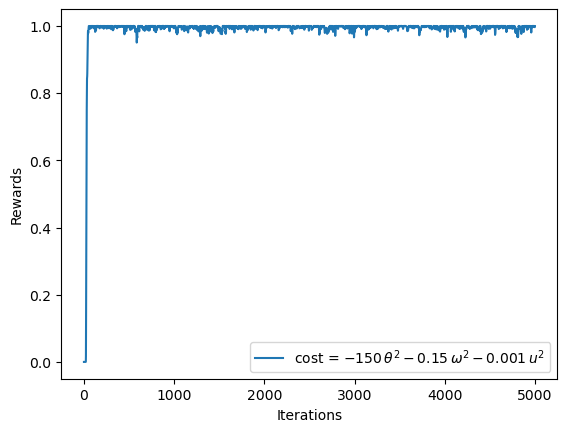

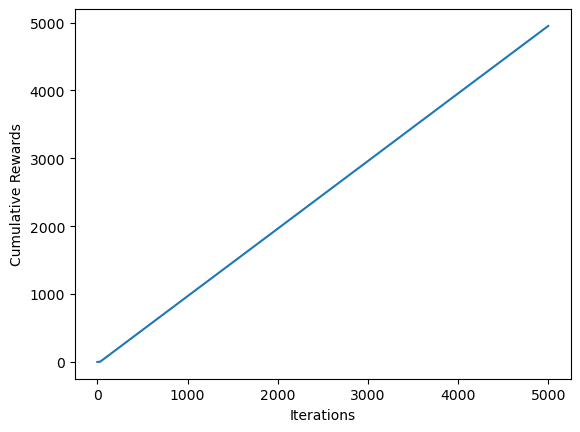

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.abs(angle_list),label='theta')
plt.plot(np.abs(target_list),label='omega')
plt.plot([np.pi]*len(target_list),'--',label='pi')
plt.plot([np.pi-np.radians(10)]*len(target_list),'--',label='-10 deg ~10 deg')
plt.xlabel('Iterations')
plt.ylabel('theta')
plt.legend()
plt.show()

plt.plot(reward_list, label='cost = $ -150\,\\theta^2 - 0.15\,\omega^2 - 0.001\,u^2$')
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.legend()
plt.show()

plt.plot(cum_reward_list)
plt.xlabel('Iterations')
plt.ylabel('Cumulative Rewards')
plt.show()